Dataset loaded successfully! Shape: (119390, 32)
Total Features: 32
Total Data Points: 119390
Numeric Features: 20
Categorical Features: 12

Missing Values:
company     112593
agent        16340
country        488
children         4
dtype: int64
Preprocessing completed!


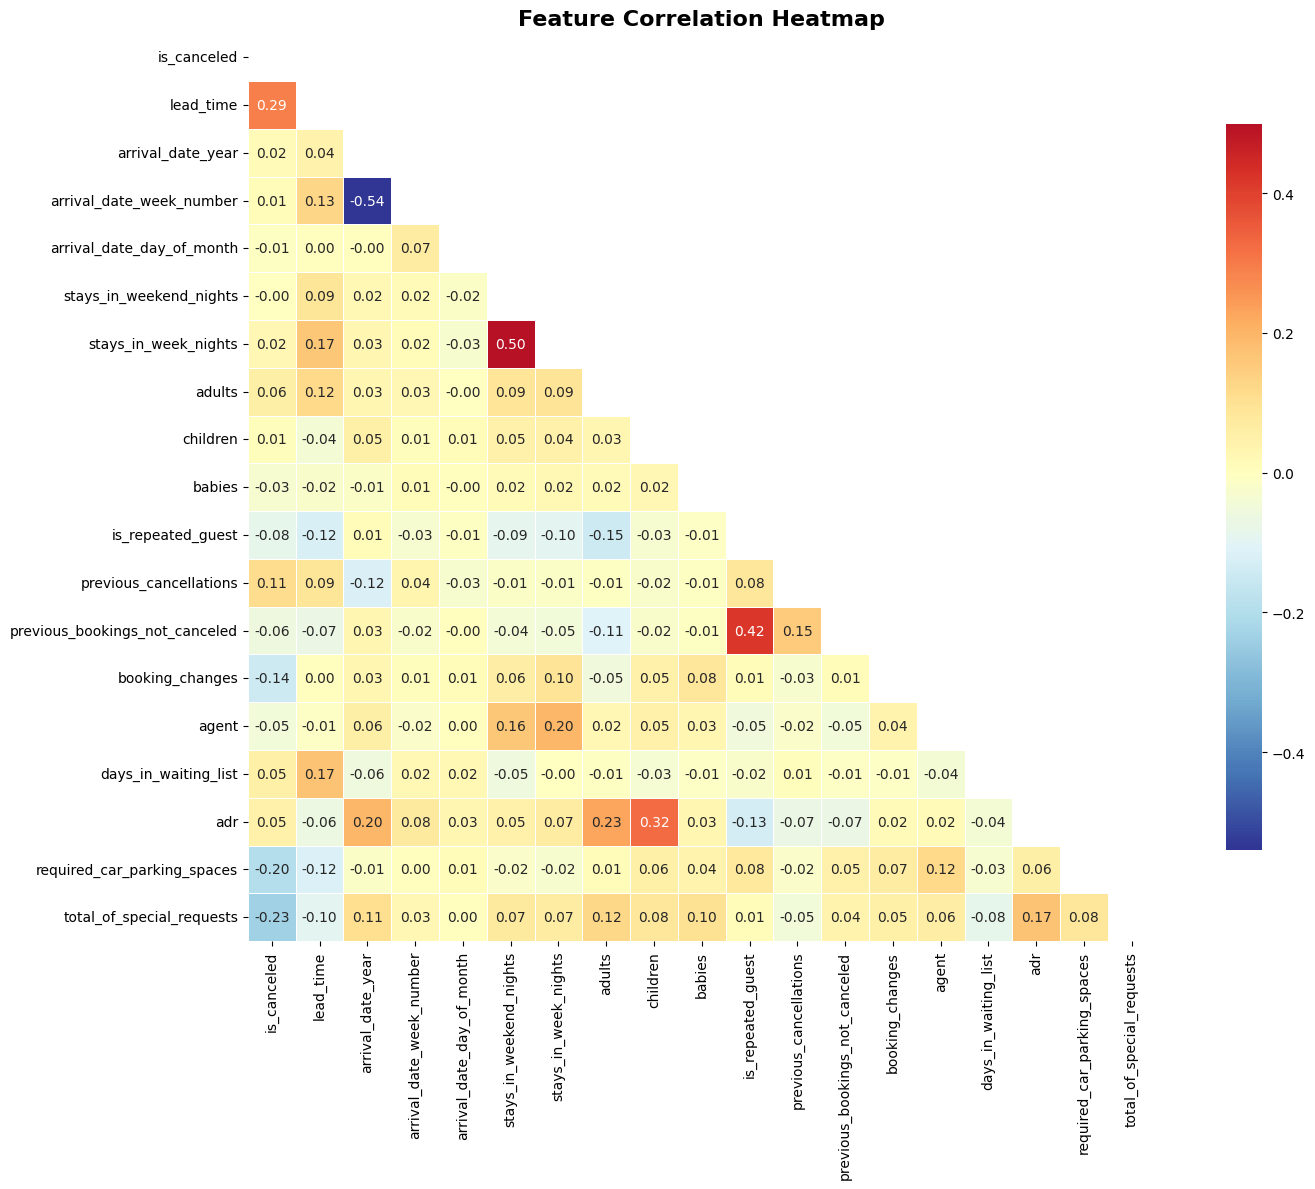


Top 5 Features Most Correlated with Cancellation:
   1. lead_time: 0.293
   2. total_of_special_requests: 0.235
   3. required_car_parking_spaces: 0.195
   4. booking_changes: 0.144
   5. previous_cancellations: 0.110

Class Distribution:
   Not Canceled (0): 75,166 (63.0%)
   Canceled (1): 44,224 (37.0%)


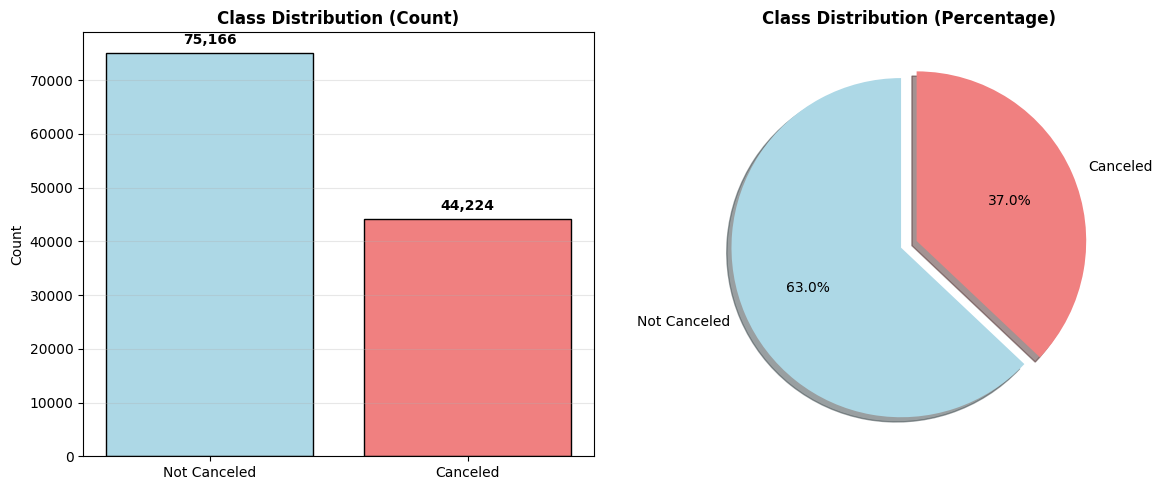

Dataset imbalance ratio: 0.59


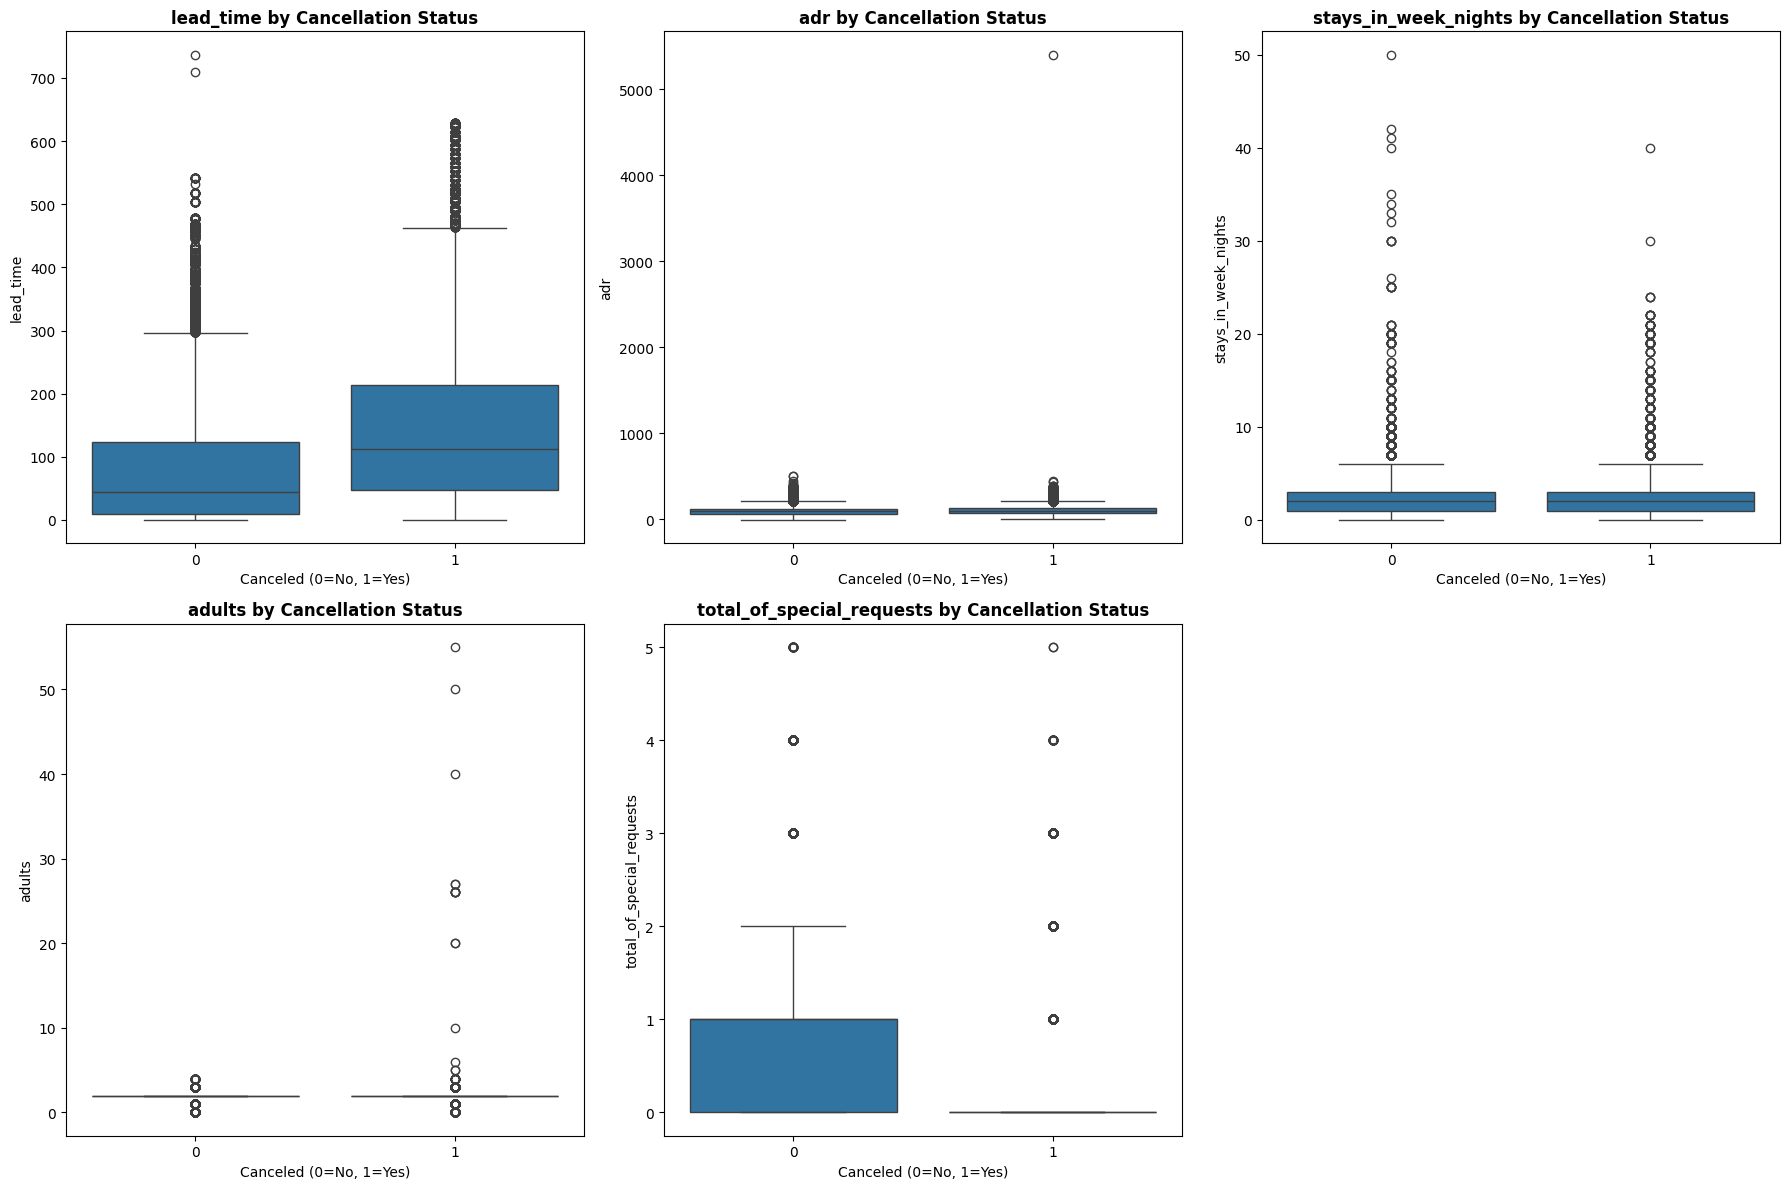

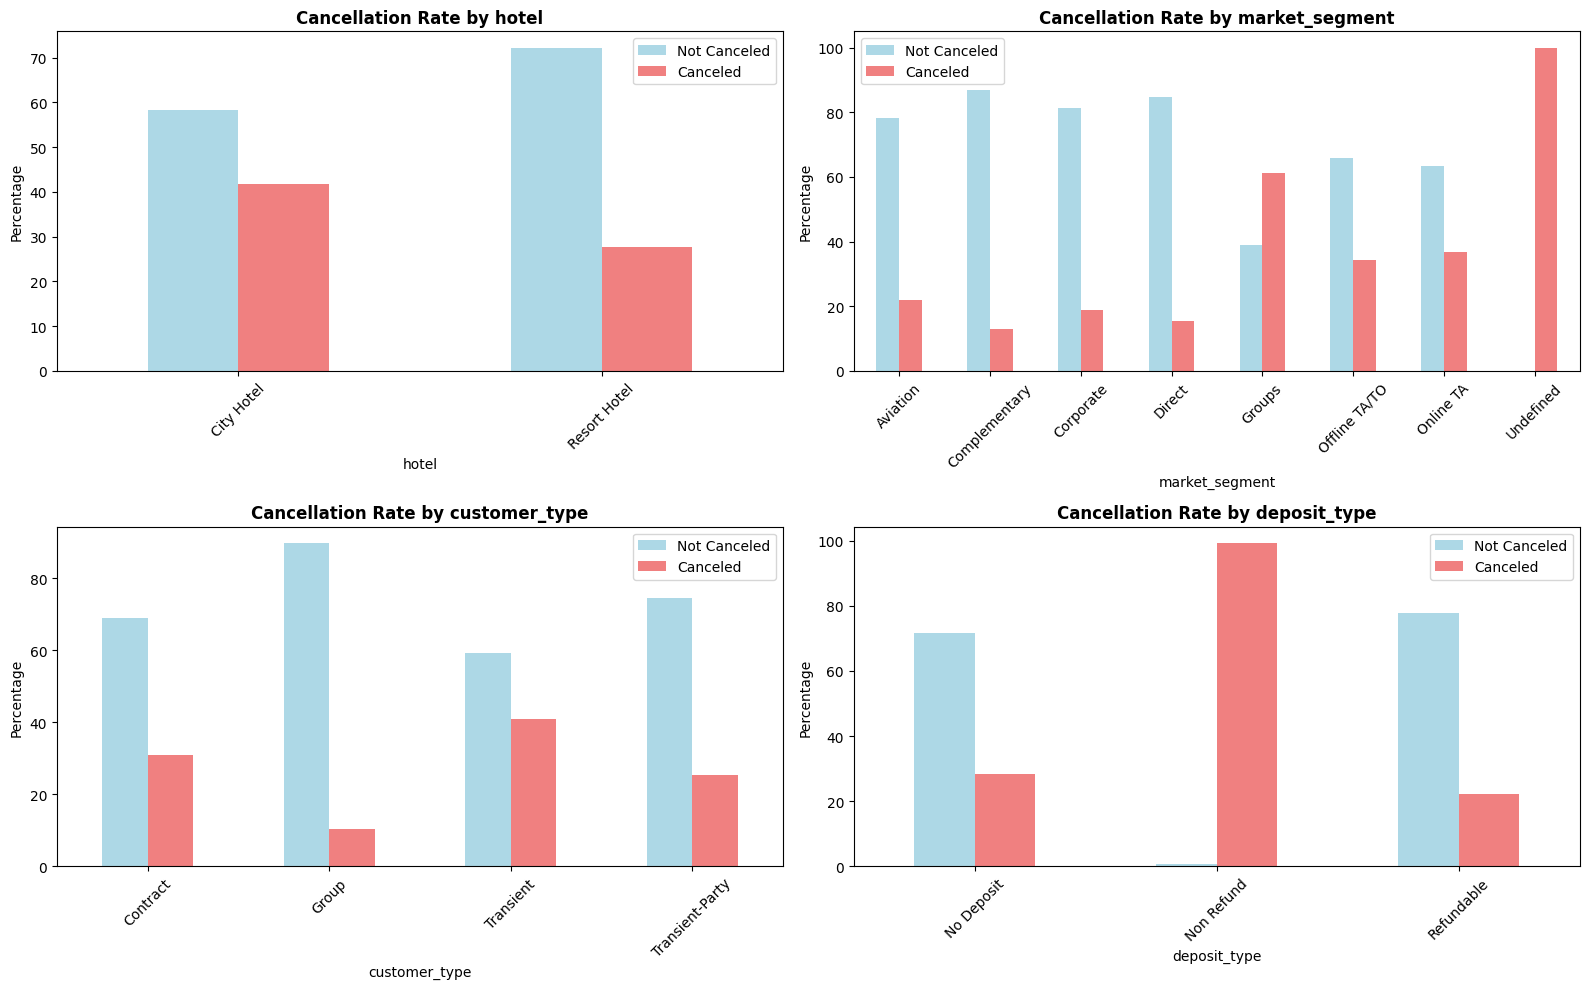


Dataset Split:
Training set: 83,573 samples (70%)
Test set: 35,817 samples (30%)

Training 5 models...
Training Neural Network...
   Neural Network - Accuracy: 0.8699
Training Decision Tree...
   Decision Tree - Accuracy: 0.8408
Training Logistic Regression...
   Logistic Regression - Accuracy: 0.8132
Training K-Nearest Neighbors...
   K-Nearest Neighbors - Accuracy: 0.8564
Training Naive Bayes...
   Naive Bayes - Accuracy: 0.7523

Model Performance Summary:
                     accuracy  precision  recall  f1_score  auc_score
Neural Network         0.8699     0.8430  0.7972    0.8195     0.9429
K-Nearest Neighbors    0.8564     0.8233  0.7798    0.8009     0.9286
Decision Tree          0.8408     0.8211  0.7292    0.7724     0.9210
Logistic Regression    0.8132     0.8081  0.6500    0.7205     0.8938
Naive Bayes            0.7523     0.9543  0.3479    0.5099     0.7987


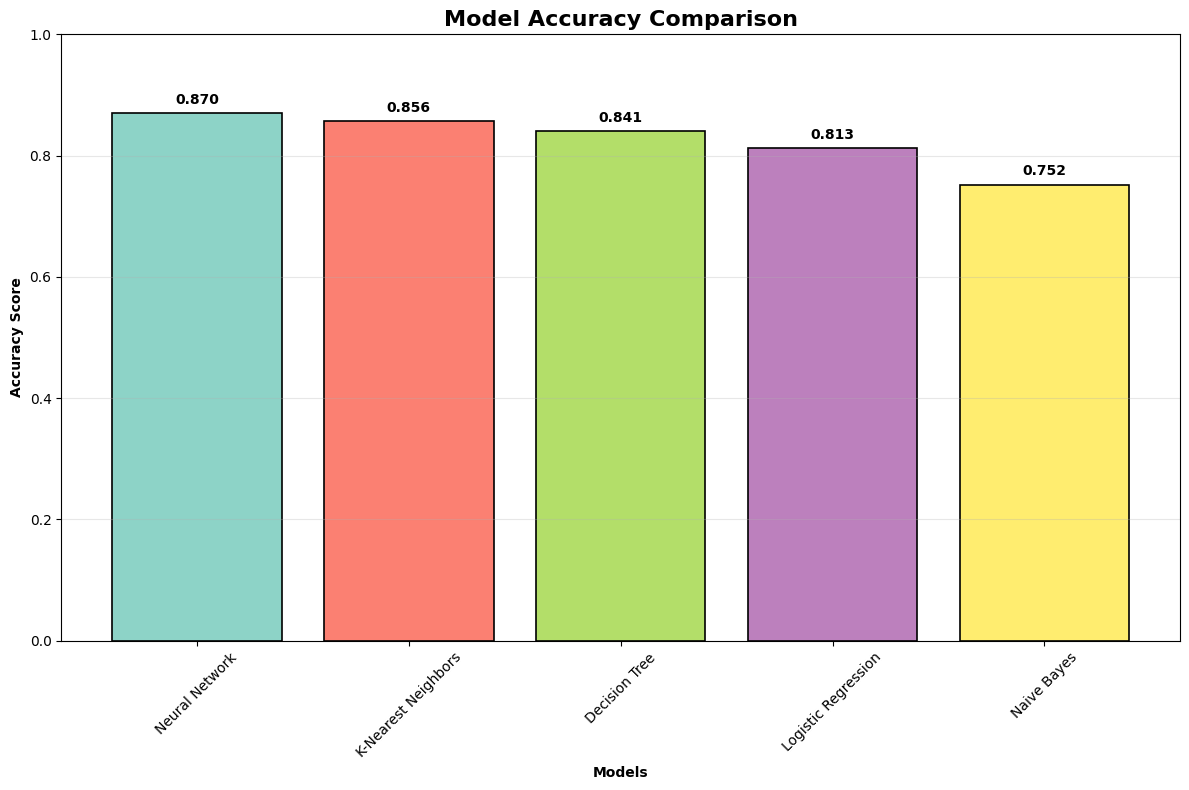

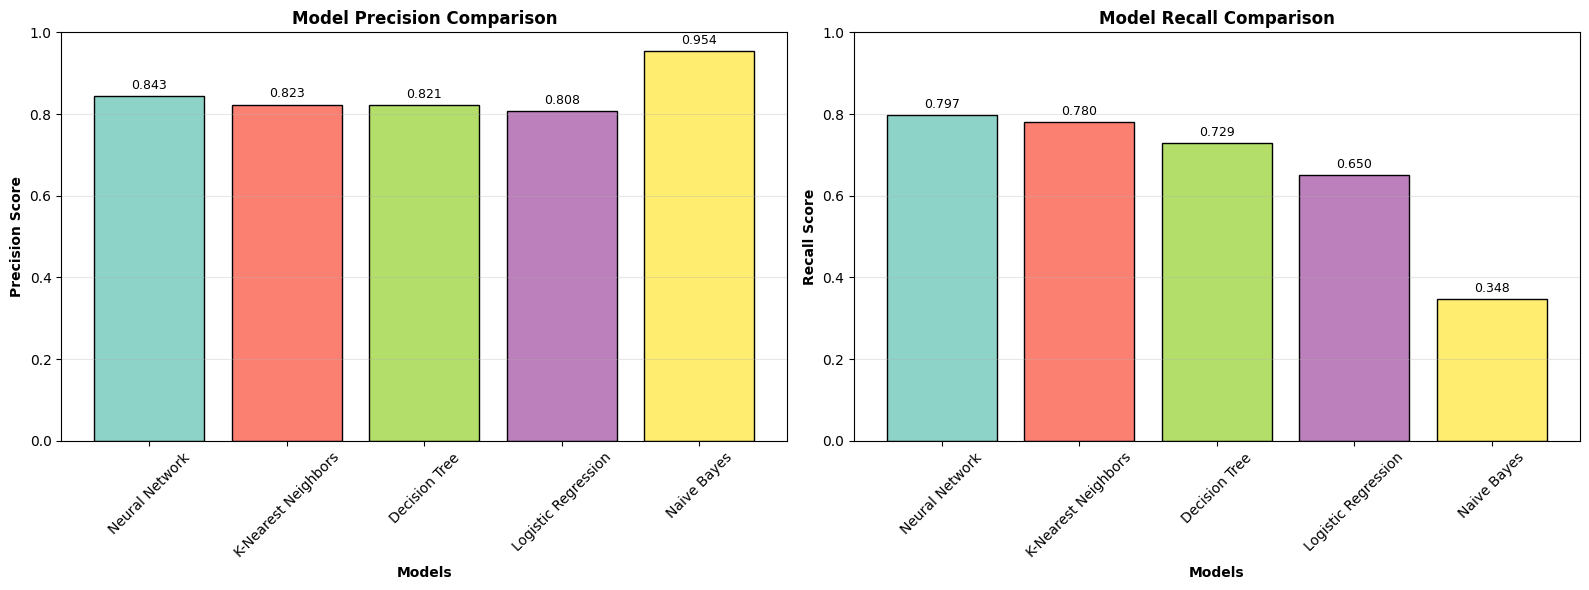

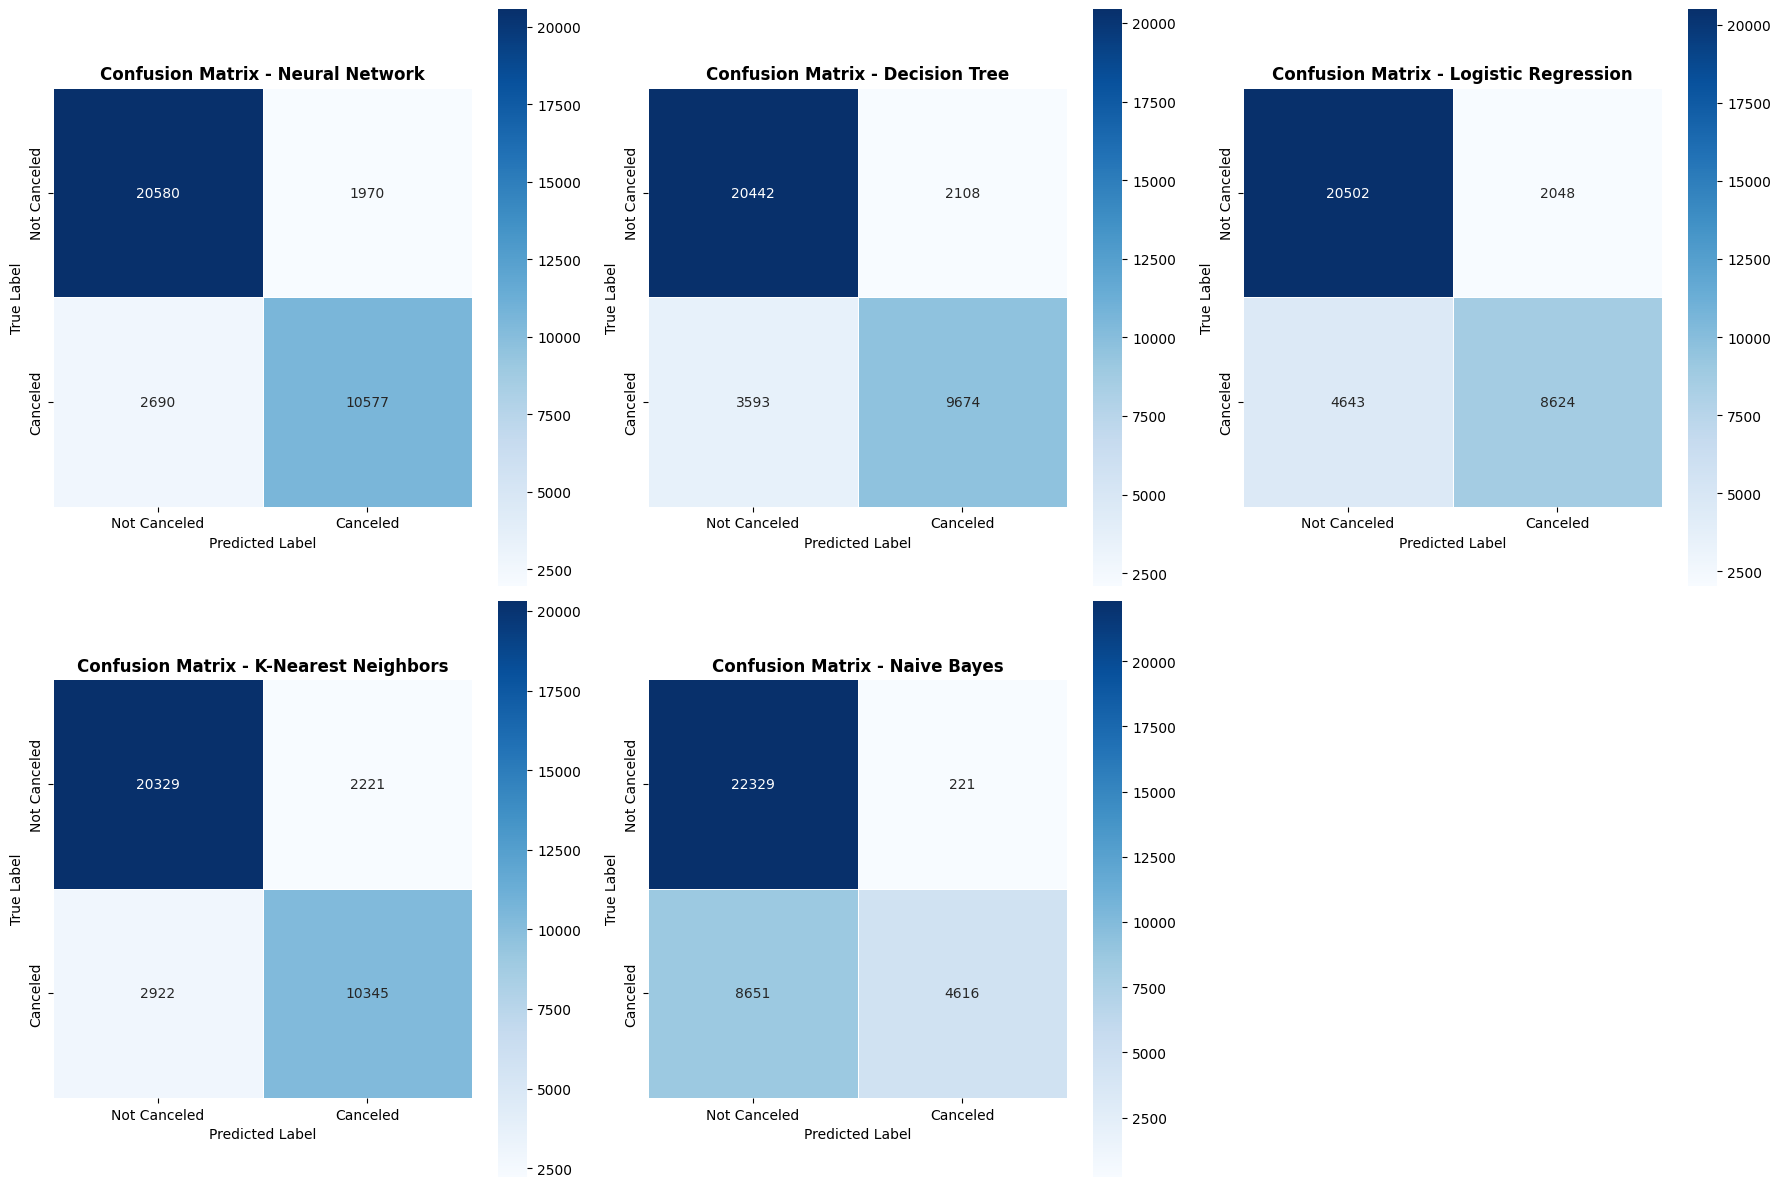

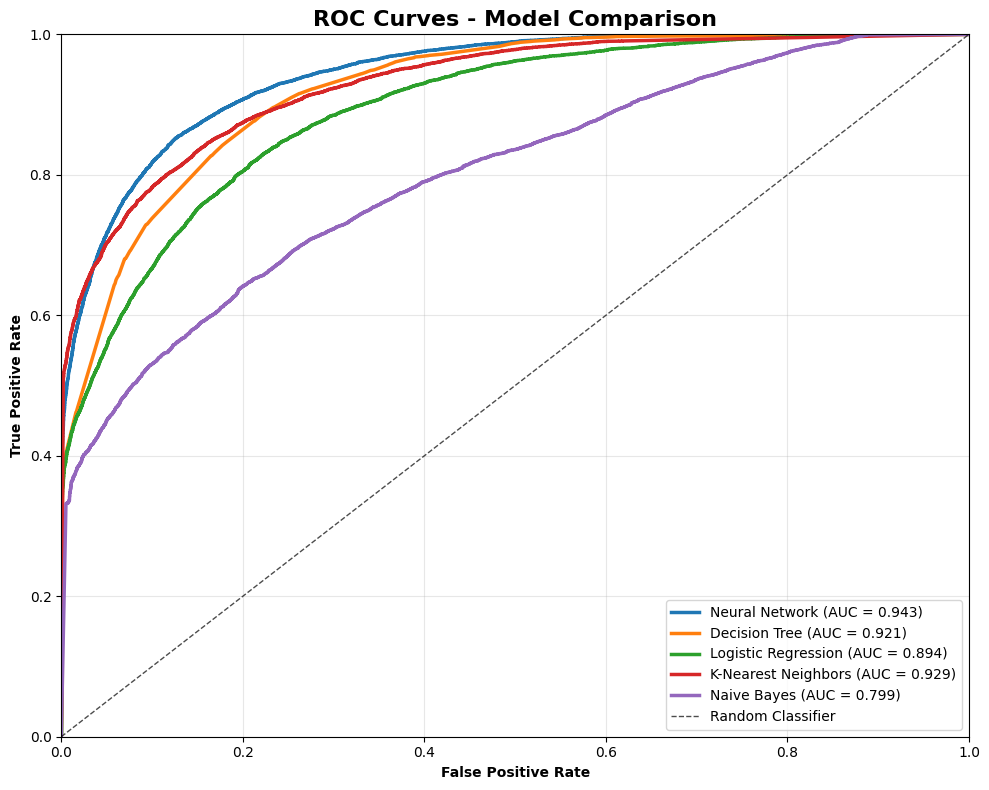

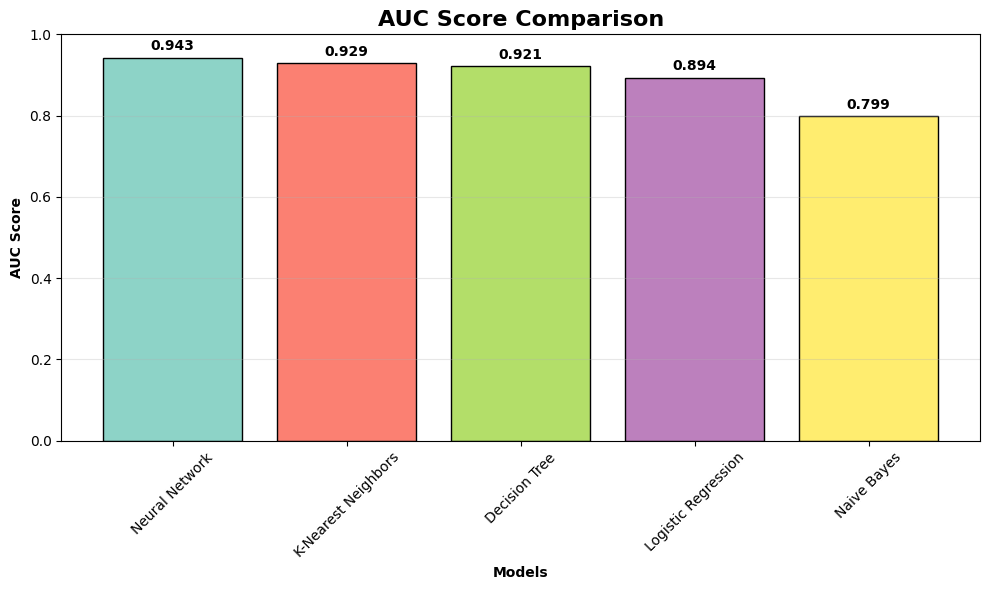


Using 7 features for clustering
Optimal number of clusters: 2


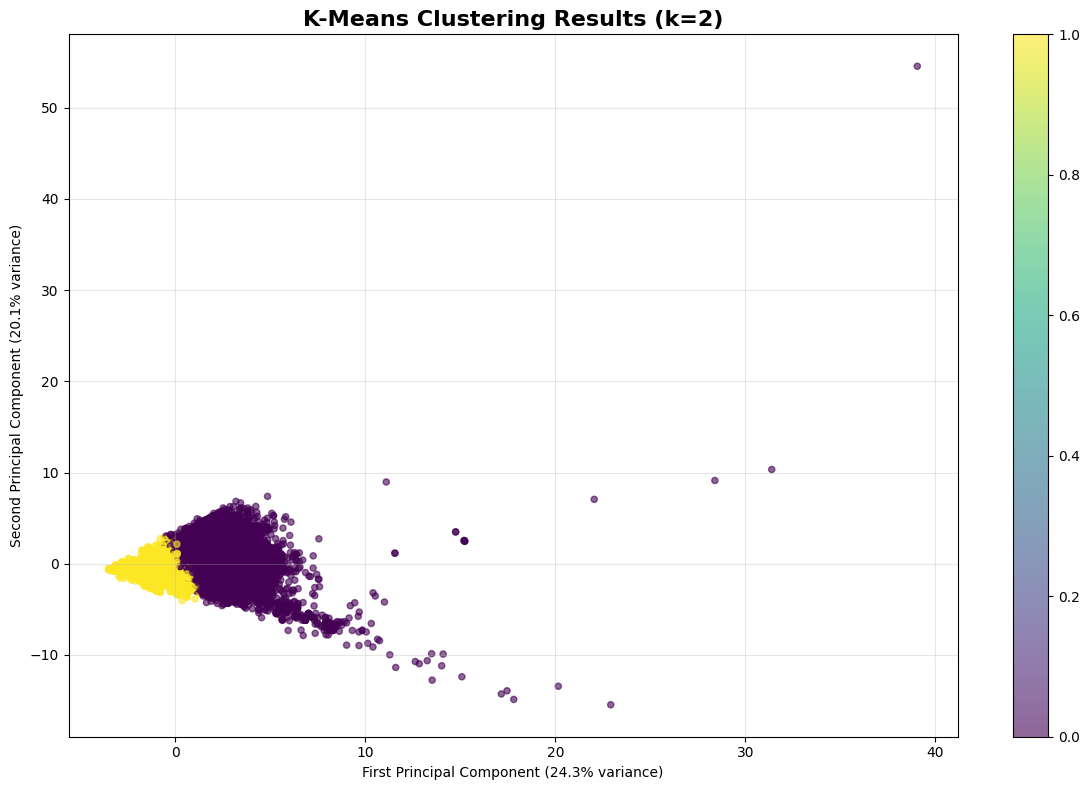


Cluster Centers:
         lead_time  stays_in_week_nights  stays_in_weekend_nights  adults  \
Cluster                                                                     
0          104.846                 3.737                    1.582   2.092   
1          103.647                 1.961                    0.642   1.753   

         children      adr  total_of_special_requests  
Cluster                                                
0           0.318  136.123                      1.172  
1           0.010   86.874                      0.309  

Cancellation Rate by Cluster:
   Cluster 0: 31.5%
   Cluster 1: 39.5%

Best Model: Neural Network
Best Accuracy: 0.8699

Classification Report - Neural Network:
              precision    recall  f1-score   support

Not Canceled       0.88      0.91      0.90     22550
    Canceled       0.84      0.80      0.82     13267

    accuracy                           0.87     35817
   macro avg       0.86      0.85      0.86     35817
weighted avg   

In [4]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import json

def run_hotel_booking_analysis():
    # Set random state for reproducibility
    RANDOM_STATE = 42
    np.random.seed(RANDOM_STATE)

    # File paths
    DATA_PATH = "hotel_bookings.csv"  # Update this path as needed
    OUTPUT_DIR = "project_outputs"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Load Dataset
    try:
        df = pd.read_csv(DATA_PATH)
        print(f"Dataset loaded successfully! Shape: {df.shape}")
    except FileNotFoundError:
        print(f"Dataset file not found: {DATA_PATH}")
        return

    TARGET = "is_canceled"
    if TARGET not in df.columns:
        print(f"Target column '{TARGET}' not found!")
        return

    # Basic dataset information
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"Total Features: {df.shape[1]}")
    print(f"Total Data Points: {df.shape[0]}")
    print(f"Numeric Features: {len(numeric_features)}")
    print(f"Categorical Features: {len(categorical_features)}")

    # Check missing values
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_data = missing_data[missing_data > 0]
    if len(missing_data) > 0:
        print("\nMissing Values:")
        print(missing_data.head())

    # Data Preprocessing
    # Drop company column (too many missing values)
    if 'company' in df.columns:
        df = df.drop(columns=['company'])

    # Handle missing values
    if 'agent' in df.columns:
        df['agent'].fillna(0, inplace=True)
    if 'children' in df.columns:
        df['children'].fillna(df['children'].median(), inplace=True)
    if 'country' in df.columns:
        df['country'].fillna(df['country'].mode()[0], inplace=True)

    # Handle categorical values
    if 'meal' in df.columns:
        df["meal"].replace("Undefined", "SC", inplace=True)

    # Remove target leakage columns
    leakage_cols = ["reservation_status", "reservation_status_date"]
    df = df.drop(columns=leakage_cols, errors='ignore')

    # Handle high cardinality
    if 'country' in df.columns:
        top_countries = df['country'].value_counts().nlargest(10).index
        df['country'] = df['country'].where(df['country'].isin(top_countries), 'Other')

    print("Preprocessing completed!")

    # Correlation Analysis
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    plt.figure(figsize=(16, 12))
    corr_matrix = df[numeric_features].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="RdYlBu_r", center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8}, fmt='.2f')
    plt.title("Feature Correlation Heatmap", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "01_correlation_heatmap.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Top correlations with target
    target_corr = corr_matrix[TARGET].abs().sort_values(ascending=False).drop(TARGET)
    print("\nTop 5 Features Most Correlated with Cancellation:")
    for i, (feature, corr) in enumerate(target_corr.head(5).items(), 1):
        print(f"   {i}. {feature}: {corr:.3f}")

    # Class Balance Analysis
    class_counts = df[TARGET].value_counts().sort_index()
    class_percentages = df[TARGET].value_counts(normalize=True).sort_index() * 100

    print(f"\nClass Distribution:")
    print(f"   Not Canceled (0): {class_counts[0]:,} ({class_percentages[0]:.1f}%)")
    print(f"   Canceled (1): {class_counts[1]:,} ({class_percentages[1]:.1f}%)")

    # Visualize class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    colors = ['lightblue', 'lightcoral']
    bars = ax1.bar(['Not Canceled', 'Canceled'], class_counts.values, color=colors, edgecolor='black')
    ax1.set_ylabel('Count')
    ax1.set_title('Class Distribution (Count)', fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)

    for bar, count in zip(bars, class_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')

    ax2.pie(class_counts.values, labels=['Not Canceled', 'Canceled'],
            autopct='%1.1f%%', colors=colors, startangle=90,
            explode=(0.05, 0.05), shadow=True)
    ax2.set_title('Class Distribution (Percentage)', fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "02_class_distribution.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Check if dataset is imbalanced
    imbalance_ratio = class_counts.min() / class_counts.max()
    print(f"Dataset imbalance ratio: {imbalance_ratio:.2f}")

    # Exploratory Data Analysis
    key_numeric_features = ['lead_time', 'adr', 'stays_in_week_nights', 'adults', 'total_of_special_requests']
    existing_numeric = [col for col in key_numeric_features if col in df.columns]

    if len(existing_numeric) >= 2:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()

        for i, feature in enumerate(existing_numeric[:6]):
            if i < len(axes):
                sns.boxplot(data=df, x=TARGET, y=feature, ax=axes[i])
                axes[i].set_title(f'{feature} by Cancellation Status', fontweight='bold')
                axes[i].set_xlabel('Canceled (0=No, 1=Yes)')

        for i in range(len(existing_numeric), len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "03_numeric_features_eda.png"), dpi=300, bbox_inches='tight')
        plt.show()

    # EDA for categorical features
    key_categorical = ['hotel', 'market_segment', 'customer_type', 'deposit_type']
    existing_categorical = [col for col in key_categorical if col in df.columns]

    if len(existing_categorical) >= 2:
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        axes = axes.flatten()

        for i, feature in enumerate(existing_categorical[:4]):
            if i < len(axes):
                ct = pd.crosstab(df[feature], df[TARGET], normalize='index') * 100
                ct.plot(kind='bar', ax=axes[i], color=['lightblue', 'lightcoral'])
                axes[i].set_title(f'Cancellation Rate by {feature}', fontweight='bold')
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('Percentage')
                axes[i].legend(['Not Canceled', 'Canceled'])
                axes[i].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "04_categorical_features_eda.png"), dpi=300, bbox_inches='tight')
        plt.show()

    # Dataset Splitting (70/30 Stratified)
    X = df.drop(columns=[TARGET])
    y = df[TARGET].values

    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
    )

    print(f"\nDataset Split:")
    print(f"Training set: {X_train.shape[0]:,} samples (70%)")
    print(f"Test set: {X_test.shape[0]:,} samples (30%)")

    # Feature Preprocessing Pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )

    # Model Training & Testing
    models = {
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            learning_rate='adaptive',
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10,
            random_state=RANDOM_STATE
        ),
        'Decision Tree': DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=RANDOM_STATE
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=RANDOM_STATE
        ),
        'K-Nearest Neighbors': KNeighborsClassifier(
            n_neighbors=15,
            weights='distance'
        ),
        'Naive Bayes': GaussianNB()
    }

    print(f"\nTraining {len(models)} models...")

    results = {}
    predictions = {}
    probabilities = {}

    # Train and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        predictions[name] = y_pred

        if hasattr(model, 'predict_proba'):
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            probabilities[name] = y_proba
        else:
            probabilities[name] = None

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        if probabilities[name] is not None:
            auc_score = roc_auc_score(y_test, probabilities[name])
        else:
            auc_score = np.nan

        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'auc_score': auc_score
        }

        print(f"   {name} - Accuracy: {accuracy:.4f}")

    # Model Comparison & Analysis
    results_df = pd.DataFrame(results).T
    results_df = results_df.round(4)
    results_df_sorted = results_df.sort_values('accuracy', ascending=False)

    print("\nModel Performance Summary:")
    print(results_df_sorted)

    results_df_sorted.to_csv(os.path.join(OUTPUT_DIR, "05_model_comparison_metrics.csv"))

    # Accuracy comparison visualization
    plt.figure(figsize=(12, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(results_df_sorted)))

    bars = plt.bar(range(len(results_df_sorted)), results_df_sorted['accuracy'],
                   color=colors, edgecolor='black', linewidth=1.2)
    plt.xlabel('Models', fontweight='bold')
    plt.ylabel('Accuracy Score', fontweight='bold')
    plt.title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
    plt.xticks(range(len(results_df_sorted)), results_df_sorted.index, rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)

    for bar, accuracy in zip(bars, results_df_sorted['accuracy']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "06_accuracy_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Precision and Recall comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    bars1 = ax1.bar(range(len(results_df_sorted)), results_df_sorted['precision'],
                    color=colors, edgecolor='black')
    ax1.set_xlabel('Models', fontweight='bold')
    ax1.set_ylabel('Precision Score', fontweight='bold')
    ax1.set_title('Model Precision Comparison', fontweight='bold')
    ax1.set_xticks(range(len(results_df_sorted)))
    ax1.set_xticklabels(results_df_sorted.index, rotation=45)
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3)

    for bar, precision in zip(bars1, results_df_sorted['precision']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{precision:.3f}', ha='center', va='bottom', fontsize=9)

    bars2 = ax2.bar(range(len(results_df_sorted)), results_df_sorted['recall'],
                    color=colors, edgecolor='black')
    ax2.set_xlabel('Models', fontweight='bold')
    ax2.set_ylabel('Recall Score', fontweight='bold')
    ax2.set_title('Model Recall Comparison', fontweight='bold')
    ax2.set_xticks(range(len(results_df_sorted)))
    ax2.set_xticklabels(results_df_sorted.index, rotation=45)
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', alpha=0.3)

    for bar, recall in zip(bars2, results_df_sorted['recall']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{recall:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "07_precision_recall_comparison.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # Confusion Matrices
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, (name, y_pred) in enumerate(predictions.items()):
        if i < len(axes):
            cm = confusion_matrix(y_test, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                       cbar=True, square=True, linewidths=0.5)
            axes[i].set_title(f'Confusion Matrix - {name}', fontweight='bold')
            axes[i].set_xlabel('Predicted Label')
            axes[i].set_ylabel('True Label')
            axes[i].set_xticklabels(['Not Canceled', 'Canceled'])
            axes[i].set_yticklabels(['Not Canceled', 'Canceled'])

    if len(predictions) < len(axes):
        axes[-1].set_visible(False)

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "08_confusion_matrices.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # ROC Curves & AUC Scores
    plt.figure(figsize=(10, 8))

    for name, y_proba in probabilities.items():
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            auc_score = roc_auc_score(y_test, y_proba)
            plt.plot(fpr, tpr, linewidth=2.5,
                    label=f'{name} (AUC = {auc_score:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.7, label='Random Classifier')

    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.ylabel('True Positive Rate', fontweight='bold')
    plt.title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "09_roc_curves.png"), dpi=300, bbox_inches='tight')
    plt.show()

    # AUC Score comparison
    auc_scores = {name: results[name]['auc_score'] for name in results.keys()
                  if not np.isnan(results[name]['auc_score'])}

    if auc_scores:
        plt.figure(figsize=(10, 6))
        sorted_auc = dict(sorted(auc_scores.items(), key=lambda x: x[1], reverse=True))

        bars = plt.bar(range(len(sorted_auc)), list(sorted_auc.values()),
                       color=colors[:len(sorted_auc)], edgecolor='black')
        plt.xlabel('Models', fontweight='bold')
        plt.ylabel('AUC Score', fontweight='bold')
        plt.title('AUC Score Comparison', fontsize=16, fontweight='bold')
        plt.xticks(range(len(sorted_auc)), list(sorted_auc.keys()), rotation=45)
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)

        for bar, auc in zip(bars, sorted_auc.values()):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "10_auc_comparison.png"), dpi=300, bbox_inches='tight')
        plt.show()

    # Unsupervised Learning: K-Means Clustering
    cluster_features = ['lead_time', 'stays_in_week_nights', 'stays_in_weekend_nights',
                       'adults', 'children', 'adr', 'total_of_special_requests']

    available_cluster_features = [col for col in cluster_features if col in df.columns]

    if len(available_cluster_features) >= 3:
        print(f"\nUsing {len(available_cluster_features)} features for clustering")

        X_cluster = df[available_cluster_features].copy()

        cluster_preprocessor = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        X_scaled = cluster_preprocessor.fit_transform(X_cluster)

        # Determine optimal number of clusters
        silhouette_scores = []
        K_range = range(2, 8)

        for k in K_range:
            kmeans_temp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
            cluster_labels = kmeans_temp.fit_predict(X_scaled)
            silhouette_avg = silhouette_score(X_scaled, cluster_labels)
            silhouette_scores.append(silhouette_avg)

        optimal_k = K_range[np.argmax(silhouette_scores)]
        print(f"Optimal number of clusters: {optimal_k}")

        # Apply K-means
        kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)

        df_cluster = df.copy()
        df_cluster['Cluster'] = cluster_labels

        # Visualize clusters using PCA
        pca = PCA(n_components=2, random_state=RANDOM_STATE)
        X_pca = pca.fit_transform(X_scaled)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels,
                             cmap='viridis', alpha=0.6, s=20)
        plt.colorbar(scatter)
        plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.title(f'K-Means Clustering Results (k={optimal_k})', fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "11_kmeans_clusters.png"), dpi=300, bbox_inches='tight')
        plt.show()

        # Cluster analysis
        cluster_summary = df_cluster.groupby('Cluster')[available_cluster_features].mean()
        print("\nCluster Centers:")
        print(cluster_summary.round(3))

        cluster_cancellation = df_cluster.groupby('Cluster')[TARGET].mean()
        print(f"\nCancellation Rate by Cluster:")
        for cluster_id, rate in cluster_cancellation.items():
            print(f"   Cluster {cluster_id}: {rate:.1%}")

    # Results Summary
    best_model = results_df_sorted.index[0]
    best_accuracy = results_df_sorted.iloc[0]['accuracy']

    print(f"\nBest Model: {best_model}")
    print(f"Best Accuracy: {best_accuracy:.4f}")

    # Classification report for best model
    best_predictions = predictions[best_model]
    print(f"\nClassification Report - {best_model}:")
    print(classification_report(y_test, best_predictions,
                               target_names=['Not Canceled', 'Canceled']))


    return {
        'results_df': results_df_sorted,
        'predictions': predictions,
        'probabilities': probabilities,
        'best_model': best_model
    }

if __name__ == "__main__":
    analysis_results = run_hotel_booking_analysis()